<a href="https://colab.research.google.com/github/sdgroeve/Machine_Learning_course_UGent_D012554_2025/blob/main/notebooks/shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Biomedical Models with SHAP

This notebook demonstrates how to use the SHAP (SHapley Additive exPlanations) framework to interpret the predictions of a machine learning model trained on a common biomedical dataset. We will predict the presence of heart disease based on clinical features using a Gradient Boosting model and then use SHAP to understand which factors drive the model's predictions, both globally and for individual patients. SHAP provides a principled way to assign importance scores to features, enhancing model transparency.

## Learning Objectives

*   Understand the intuition behind Shapley values and the SHAP framework
*   Generate global and local explanations for a tree-based model trained on biomedical data
*   Recognize common pitfalls when interpreting SHAP in health contexts

## Environment & Data Sources

*   **Python:** 3.x
*   **Libraries:** `shap` (0.45.0 specified), `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn` (optional, for aesthetics), `joblib` (for saving)
*   **Dataset:** We will use the **UCI Heart Disease dataset**. This dataset contains 14 attributes collected from patients, aiming to predict the presence or absence of heart disease. A processed version is conveniently available via the `shap` library itself.
    *   *Source:* [https://archive.ics.uci.edu/ml/datasets/heart+Disease](https://archive.ics.uci.edu/ml/datasets/heart+Disease)

In [4]:
# NOTE: The original request included an install command.
# If running locally or in an environment where packages aren't pre-installed, uncomment the line below.
# !pip install shap==0.45.0 scikit-learn pandas matplotlib seaborn joblib -q

# Import necessary libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pathlib
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier

# Set plotting style and ensure plots appear inline
sns.set_style("whitegrid")
%matplotlib inline

# Print library versions
print(f"SHAP version: {shap.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Joblib version: {joblib.__version__}")

SHAP version: 0.47.1
Pandas version: 2.2.2
Numpy version: 2.0.2
Scikit-learn version: 1.6.1
Joblib version: 1.4.2


## 1. Data Loading & Initial Glance

We load the UCI Heart Disease dataset. The features include:

*   **Age:** Age in years
*   **Sex:** (1 = male; 0 = female)
*   **ChestPain:** Chest pain type (e.g., typical angina, atypical angina)
*   **RestBP:** Resting blood pressure (mm Hg)
*   **Chol:** Serum cholesterol (mg/dl)
*   **Fbs:** Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
*   **RestECG:** Resting electrocardiographic results
*   **MaxHR:** Maximum heart rate achieved
*   **ExAng:** Exercise induced angina (1 = yes; 0 = no)
*   **Oldpeak:** ST depression induced by exercise relative to rest
*   **Slope:** The slope of the peak exercise ST segment
*   **Ca:** Number of major vessels (0-3) colored by fluoroscopy
*   **Thal:** Thalassemia defect type

**Target Label:**
*   **output:** Presence of heart disease (1 = True, 0 = False). This is our prediction target.

*Protected Attributes Note:* Features like 'Age' and 'Sex' are often considered protected attributes in fairness analysis. While we use them here for demonstrating SHAP, a real-world application would require careful consideration of potential biases (discussed later).

In [11]:
d = fetch_openml(data_id=43398,as_frame=True)
d.frame

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57.0,0.0,0.0,140.0,241.0,0.0,1.0,123.0,1.0,0.2,1.0,0.0,3.0,0.0
299,45.0,1.0,3.0,110.0,264.0,0.0,1.0,132.0,0.0,1.2,1.0,0.0,3.0,0.0
300,68.0,1.0,0.0,144.0,193.0,1.0,1.0,141.0,0.0,3.4,1.0,2.0,3.0,0.0
301,57.0,1.0,0.0,130.0,131.0,0.0,1.0,115.0,1.0,1.2,1.0,1.0,3.0,0.0


In [12]:
y_raw = d.frame.pop('target')
X_raw = d.frame

# Display basic information
print("Dataset shape (features):", X_raw.shape)
print("Dataset shape (target):", y_raw.shape)

print("\nFirst 5 rows of features (X):")
print(X_raw.head())

print("\nFirst 5 rows of target (y):")
print(pd.Series(y_raw).head()) # Convert numpy array to Series for display

print("\nData types and missing values:")
print(X_raw.info())

print("\nMissing value counts per column:")
print(X_raw.isnull().sum())

# Check target distribution
print("\nTarget variable distribution:")
print(pd.Series(y_raw).value_counts(normalize=True))

Dataset shape (features): (303, 13)
Dataset shape (target): (303,)

First 5 rows of features (X):
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  
0    0.0  0.0   1.0  
1    0.0  0.0   2.0  
2    2.0  0.0   2.0  
3    2.0  0.0   2.0  
4    2.0  0.0   2.0  

First 5 rows of target (y):
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: target, dtype: float64

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    -------------

## 2. Biomedical-Driven Pre-processing

The dataset loaded via `shap.datasets.heart()` is already relatively clean:
*   **Missing Values:** No missing values are present in this version. In a typical biomedical dataset, missing values are common and require careful handling (e.g., median imputation for skewed distributions, mean imputation, or more sophisticated methods like K-Nearest Neighbors imputation, considering clinical plausibility).
*   **Categorical Encoding:** The features appear to be numerically encoded already. If we had categorical strings (e.g., 'Male'/'Female'), we would need encoding (One-Hot Encoding is common, Target Encoding can be useful but risks target leakage if not done carefully within cross-validation).
*   **Train/Validation/Test Split:** We need to split the data to train the model and evaluate its performance and interpretations on unseen data. A standard split (e.g., 70% train, 30% validation/test) is sufficient here. For datasets with multiple records per patient, patient-level splitting is crucial to prevent data leakage. We'll use a simple random split for this example. We'll use `validation` terminology for the set used for SHAP analysis, which also serves as our test set for performance evaluation in this simpler setup. We use `random_state` for reproducibility.

In [13]:
# Split data into training and validation/test sets
# Using 70% for training and 30% for validation/testing
X_train, X_val, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42, stratify=y_raw)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (212, 13)
Validation set shape: (91, 13)


## 3. Train a Predictive Model

We will train a **Gradient Boosting Classifier (GBC)**.
*   **Why GBC?** It's a powerful tree-based ensemble model often achieving good performance on tabular data. Crucially, SHAP has a highly optimized and exact algorithm (`TreeSHAP`) specifically for tree-based models like GBC, LightGBM, and XGBoost, making interpretation efficient and accurate.

*   **Performance:** Before interpreting a model, it's essential to verify it has reasonable predictive power. We'll evaluate the model using **Area Under the Receiver Operating Characteristic Curve (AUROC)** and **Area Under the Precision-Recall Curve (PR-AUC)** on the validation set. High performance suggests the model has learned meaningful patterns from the data, making its explanations more likely to be insightful. Interpretability methods applied to poorly performing models yield unreliable insights.

In [14]:
# Initialize and train the Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities on the validation set (needed for AUC calculation)
y_pred_proba = model.predict_proba(X_val)[:, 1] # Probability of the positive class (heart disease)

# Calculate performance metrics
auroc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"Model Performance on Validation Set:")
print(f"AUROC: {auroc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

# Check if performance is reasonable (e.g., AUROC > 0.7 is often considered acceptable, > 0.8 good)
if auroc < 0.7:
    print("\nWarning: Model performance is relatively low. Interpretations might be less reliable.")

Model Performance on Validation Set:
AUROC: 0.8434
PR-AUC: 0.8617


## 4. A 5-Minute SHAP Theory Primer

*   **Origin:** Shapley values come from cooperative game theory, designed to fairly distribute the "payout" (model prediction) among "players" (features).
*   **SHAP:** SHAP (SHapley Additive exPlanations) adapts this concept for machine learning models. It guarantees certain desirable properties for feature attributions:
    *   **Local Accuracy:** The sum of SHAP values for a single prediction equals the difference between the model's output for that instance and the baseline (average) prediction. `sum(shap_values[i]) ≈ model.predict(xi) - baseline`
    *   **Missingness:** Features that are truly missing in the input data (or assigned a value indicating absence) should have a SHAP value of zero.
    *   **Consistency:** If a model changes so that a feature's marginal contribution increases or stays the same (regardless of other features), its SHAP value should not decrease.
*   **Intuition:** A feature's SHAP value represents its average marginal contribution to the prediction across all possible combinations (coalitions) of other features. It quantifies how much this feature's value pushed the prediction away from the average prediction.
*   **Explainer Types:** SHAP provides different explainers optimized for various model types:
    *   **TreeSHAP:** Fast and exact for tree-based models (like the GBC we are using).
    *   **KernelSHAP:** Model-agnostic, works for any model but can be slower. Approximates Shapley values.
    *   **DeepSHAP (DeepLIFT):** Optimized for deep learning models.
    *   *Others:* GradientExplainer, LinearExplainer, etc.

## 5. Computing SHAP Values

Since we trained a `GradientBoostingClassifier`, we use `shap.TreeExplainer`. We compute the SHAP values for our validation set (`X_val`). This calculates the contribution of each feature to the prediction for every patient in the validation set. The result is typically a NumPy array where rows correspond to patients and columns correspond to features. For binary classification, `shap_values` often represent the impact on the probability of the positive class (class 1, i.e., presence of heart disease).

In [15]:
# Initialize the SHAP explainer for our tree-based model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the validation set
# For GBC binary classification, shap_values usually correspond to the positive class (class 1)
shap_values_array = explainer.shap_values(X_val) # returns ndarray

# For newer SHAP versions, explainer(X_val) returns a richer Explanation object
# This is often preferred for plotting and analysis
shap_values_exp = explainer(X_val)

# Check the shape of the SHAP values array
print("SHAP values array shape:", shap_values_array.shape) # Should be (n_samples_val, n_features)
# Check the type and structure of the Explanation object
print("SHAP Explanation object type:", type(shap_values_exp))

SHAP values array shape: (91, 13)
SHAP Explanation object type: <class 'shap._explanation.Explanation'>


## 6. Global Feature Importance

We can get a global understanding of feature importance by averaging the *absolute* SHAP values across all samples. This `mean(|SHAP value|)` indicates the average magnitude of impact a feature has on the model's predictions.

*   **Difference from Model Importance:** Standard feature importance metrics from tree models (like Gini importance or permutation importance) measure how useful a feature is for splitting nodes or how much performance drops when shuffled, respectively. SHAP values provide a more nuanced view based on the magnitude and direction of impact on the *model output scale* (e.g., log-odds for classifiers).
*   **Biomedical Angle:** Do the top features identified by SHAP align with known clinical risk factors for heart disease? For example, we might expect `ChestPain`, `MaxHR`, `Age`, `Chol`, and `Thal` to be important. Unexpected high importance for a feature might warrant further investigation (is it a true finding, or an artifact of the data/model?).

We can visualize this using a bar plot or a beeswarm plot. The beeswarm plot is particularly informative as it shows the distribution of SHAP values for each feature, revealing not just importance but also the *direction* of the effect (e.g., high cholesterol generally increases risk prediction).

Global Feature Importance (Bar Plot):


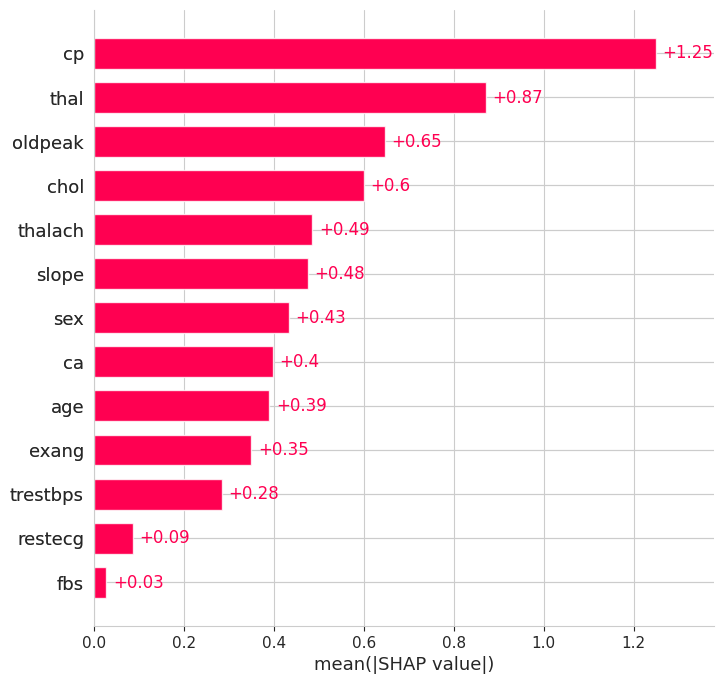


Global Feature Importance (Beeswarm Plot):


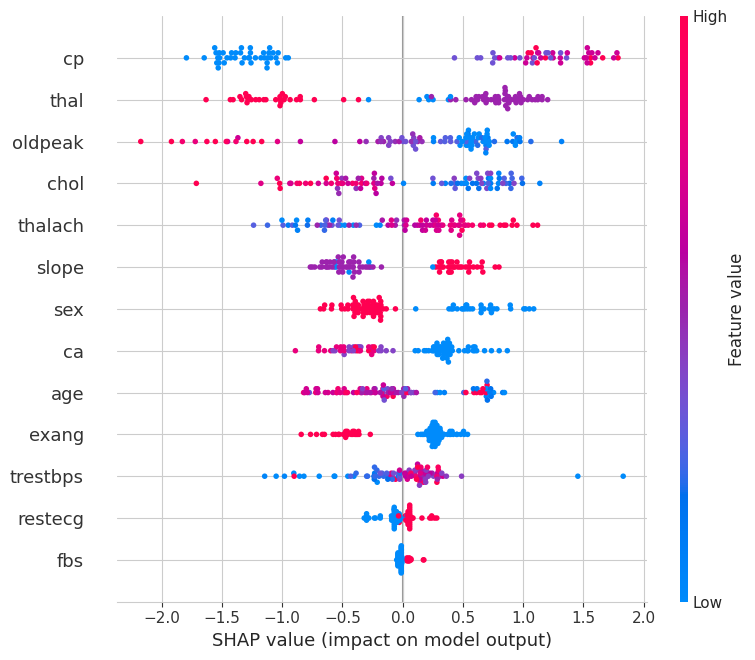

In [16]:
# Using the Explanation object directly for plotting (newer API)

# Bar plot: Shows mean absolute SHAP value per feature
print("Global Feature Importance (Bar Plot):")
shap.plots.bar(shap_values_exp, max_display=15) # Show top 15 features
plt.show() # Ensure plot is displayed

# Beeswarm plot: Shows SHAP value distribution for each feature
# Color represents feature value (red=high, blue=low)
print("\nGlobal Feature Importance (Beeswarm Plot):")
shap.summary_plot(shap_values_exp, X_val, max_display=15) # Default plot_type='dot' (beeswarm)
# No plt.show() needed for summary_plot typically, but added for consistency if needed

**Interpretation of Beeswarm:**
*   Each point is a patient-feature SHAP value.
*   **X-axis:** SHAP value (impact on model output, positive pushes towards heart disease prediction).
*   **Y-axis:** Features, ordered by global importance (mean absolute SHAP value).
*   **Color:** Feature value for that patient (high=red, low=blue).

For example, for `ChestPain`, we might see that low values (blue points, potentially indicating typical angina) have positive SHAP values (pushing towards disease prediction), while high values (red points, asymptomatic) have negative SHAP values. For `MaxHR`, high values (red) likely have negative SHAP values (protective), while low values (blue) have positive SHAP values (risk factor).

## 7. Dependence & Interaction Plots

SHAP dependence plots show how the model's prediction for a single feature changes as the feature's value varies. We can also visualize interaction effects by coloring the points based on the value of a second feature.

*   **Example:** How does the impact of maximum heart rate (`MaxHR`) change with patient `Age`? Does high cholesterol (`Chol`) affect risk differently for younger vs. older patients?
*   **Warning:** These plots show correlations learned by the model, *not necessarily causation*. Also, be cautious about interpreting patterns in sparse regions of the plot where there is little data support (extrapolation).

In [17]:
# Dependence plot for 'MaxHR' (Maximum Heart Rate Achieved)
# Color points by 'Age' to see potential interaction
print("SHAP Dependence Plot for MaxHR, colored by Age:")
shap.dependence_plot("MaxHR", shap_values_array, X_val, interaction_index="Age")

# Dependence plot for 'Chol' (Cholesterol)
# Color points by 'Age'
print("\nSHAP Dependence Plot for Chol, colored by Age:")
shap.dependence_plot("Chol", shap_values_array, X_val, interaction_index="Age")

# Dependence plot for 'ChestPain'
# Color points by 'Sex' (might show different patterns for males/females if Sex is important)
print("\nSHAP Dependence Plot for ChestPain, colored by Sex:")
shap.dependence_plot("ChestPain", shap_values_array, X_val, interaction_index="Sex")

SHAP Dependence Plot for MaxHR, colored by Age:


ValueError: Could not find feature named: MaxHR

**Interpretation of Dependence Plot:**
*   **Y-axis:** SHAP value for the feature on the X-axis.
*   **X-axis:** Value of the feature being plotted.
*   **Color:** Value of the `interaction_index` feature.

Look for trends (e.g., does the SHAP value for `MaxHR` generally decrease as `MaxHR` increases?) and vertical dispersion/patterns introduced by the interaction feature (e.g., are the red points consistently higher/lower than the blue points for a given `MaxHR` value?).

## 8. Local (Per-Patient) Explanations

SHAP excels at explaining individual predictions. Waterfall plots and force plots visualize how each feature contributes to moving the prediction for a single patient away from the baseline (average) prediction.

*   **Sign Convention:**
    *   **Positive SHAP values (red arrows in waterfall):** Features pushing the prediction towards 1 (presence of heart disease).
    *   **Negative SHAP values (blue arrows in waterfall):** Features pushing the prediction towards 0 (absence of heart disease).
*   **Baseline:** The `explainer.expected_value` represents the average prediction across the training dataset (often corresponds to the prevalence of the positive class in log-odds space).
*   **Clinical Storytelling:** These plots can help explain a specific patient's risk profile. Start with the baseline risk (`E[f(X)]`), then describe how each key feature (e.g., high cholesterol, specific chest pain type, older age) adds to or subtracts from that baseline risk to arrive at the final prediction (`f(x)`).

In [ ]:
# Choose an example patient index from the validation set
idx = 7 # You can change this index to explore different patients

# Initialize JavaScript visualization in the notebook for force plots
shap.initjs()

# Explain the prediction for this patient using a waterfall plot
print(f"Waterfall plot for patient index {idx}:")

# We need to create a SHAP Explanation object for a single instance for the waterfall plot
# The base_values should be the explainer's expected value (average prediction)
# The values are the SHAP values for this instance
# The data is the feature values for this instance
patient_explanation = shap.Explanation(values=shap_values_array[idx],
                                       base_values=explainer.expected_value,
                                       data=X_val.iloc[idx],
                                       feature_names=X_val.columns.tolist())

shap.plots.waterfall(patient_explanation, max_display=15)
plt.show() # Ensure plot is displayed

# Explain the prediction using a force plot
print(f"\nForce plot for patient index {idx}:")
# Use the Explanation object slice directly (preferred way)
shap.plots.force(shap_values_exp[idx])

# Example: Force plot for multiple samples (can be slow/cluttered for too many)
# print("\nForce plot for the first 5 validation samples:")
# shap.plots.force(shap_values_exp[:5])

**Interpretation of Local Plots:**
*   **Waterfall:** Starts at the bottom with the base value (`E[f(X)]`). Each arrow represents a feature's contribution, adding (red) or subtracting (blue) from the value. The final value at the top (`f(x)`) is the model's output for this patient (often in log-odds). Features are typically ordered by the magnitude of their contribution.
*   **Force Plot:** Shows the same information horizontally. Red features push the prediction higher (right), blue features push it lower (left). The width of the bar represents the magnitude of the SHAP value. The final prediction value is shown, along with the base value.

## 9. Model-Reliability Checks

While SHAP provides detailed explanations, it's crucial to perform sanity checks and understand its limitations, especially in high-stakes domains like healthcare.

*   **Compare to Domain Knowledge:** Does the global SHAP importance ranking align with established clinical risk factors? Are the directions of effects (e.g., high cholesterol increases risk) clinically plausible? Significant deviations warrant investigation.
*   **Compare to Simpler Methods:** Does the SHAP ranking roughly align with univariate analyses (e.g., odds ratios from logistic regression on single features)? While SHAP captures interactions and non-linearities, major discrepancies might indicate issues.
*   **Partial Dependence Plots (PDP):** PDPs show the average marginal effect of a feature. Compare the trend in a SHAP dependence plot (which shows individual conditional effects) to the corresponding PDP (which shows the average effect). They should generally align, though SHAP provides more granular detail.
*   **Limitations:**
    *   **Correlated Features:** SHAP, like Shapley values, can distribute the importance among highly correlated features. This might dilute the apparent importance of a single feature if it has strong correlates also included in the model.
    *   **Association vs. Causation:** SHAP explains *what* the model learned, which is based on associations in the data. It does *not* imply causality. A feature might be important because it's a proxy for an unmeasured causal factor.
    *   **Measurement Errors:** Errors or biases in how data was collected (e.g., lab measurement variability) can affect the model and its explanations. SHAP reflects the model's behavior on the given data, including its flaws.
    *   **Model Dependence:** SHAP explains the *trained model*, not the underlying real-world process directly. Different models trained on the same data might yield different SHAP explanations.

## 10. Fairness & Ethics Sidebar (Optional but Recommended)

SHAP can be a tool for auditing fairness, but requires careful application.

*   **Auditing Protected Attributes:** Analyze the SHAP values for protected attributes (e.g., `Sex`, `Age` in this dataset) or features highly correlated with them (e.g., zip code as a proxy for race or socioeconomic status).
    *   Does the model assign high importance to these features?
    *   Are there significant differences in SHAP value distributions across different demographic groups (e.g., using beeswarm plots stratified by group)? This could indicate potential bias where the model relies differently on features for different groups.
*   **When NOT to Show Explanations:**
    *   **Privacy:** Explanations, especially local ones, reveal information about how a prediction was made based on sensitive input data. Sharing detailed explanations might inadvertently leak private information.
    *   **Cognitive Overload / Misinterpretation:** Complex explanations might overwhelm or mislead users (clinicians, patients) if not presented clearly and with appropriate caveats. Over-simplification can also be dangerous.
    *   **Gaming the System:** Detailed explanations could potentially be used by adversarial actors to manipulate inputs to achieve a desired outcome.

Ethical use of model explanations requires balancing transparency with potential harms and ensuring interpretations are accurate and actionable.

## 11. Saving & Sharing Explanations

Computing SHAP values, especially with KernelSHAP or for large datasets, can be time-consuming. It's often useful to save the computed values for later analysis or sharing.

*   **Saving:** We can save the SHAP values array (e.g., using `joblib` or saving to formats like `.npy`, `.parquet`, `.feather`). Saving the `Explanation` object directly might be possible but can sometimes have serialization issues depending on the object's complexity; saving the core components (`.values`, `.base_values`, `.data`) might be more robust.
*   **Sharing:** Individual plots (like waterfalls) can be saved as images. Force plots can be saved as HTML for interactive viewing (`shap.save_html`).

In [ ]:
# Create an output directory if it doesn't exist
output_dir = pathlib.Path("outputs")
output_dir.mkdir(exist_ok=True)

# Save the SHAP values array (NumPy array)
shap_values_filename = output_dir / "shap_values_heart_disease.pkl"
joblib.dump(shap_values_array, shap_values_filename)
print(f"SHAP values array saved to: {shap_values_filename}")

# Optionally, save the explainer's expected value (useful for reconstructing explanations)
expected_value_filename = output_dir / "explainer_expected_value.pkl"
joblib.dump(explainer.expected_value, expected_value_filename)
print(f"Explainer expected value saved to: {expected_value_filename}")

# Example: Save a specific waterfall plot as an image file
idx_to_save = 10
patient_explanation_to_save = shap.Explanation(values=shap_values_array[idx_to_save],
                                                base_values=explainer.expected_value,
                                                data=X_val.iloc[idx_to_save],
                                                feature_names=X_val.columns.tolist())

waterfall_img_filename = output_dir / f"waterfall_patient_{idx_to_save}.png"
fig, ax = plt.subplots() # Create a figure to save
shap.plots.waterfall(patient_explanation_to_save, max_display=15, show=False) # Draw on the ax
fig.savefig(waterfall_img_filename, bbox_inches='tight') # Save the figure
plt.close(fig) # Close the figure to prevent displaying it here
print(f"Waterfall plot image saved for patient {idx_to_save} to: {waterfall_img_filename}")

# Example: Save a force plot as HTML
force_plot_html_filename = output_dir / f"force_plot_patient_{idx_to_save}.html"
# Need to pass the specific Explanation slice to shap.plots.force
force_plot_obj = shap.plots.force(shap_values_exp[idx_to_save])
shap.save_html(str(force_plot_html_filename), force_plot_obj)
print(f"Force plot HTML saved for patient {idx_to_save} to: {force_plot_html_filename}")

## 12. Conclusions & Takeaways

This notebook demonstrated the application of SHAP for interpreting a Gradient Boosting model trained on the UCI Heart Disease dataset.

*   **Key Findings:**
    *   We identified the globally most important features driving heart disease predictions (e.g., `ChestPain`, `Thal`, `Ca`, `MaxHR`). The beeswarm plot provided insights into the direction and distribution of these impacts.
    *   Dependence plots illustrated non-linear relationships and potential interactions (e.g., the effect of `MaxHR` potentially varying with `Age`).
    *   Local waterfall and force plots allowed us to dissect the prediction for individual patients, showing how specific clinical factors contributed to their predicted risk.
*   **Actionability:**
    *   **Clinicians:** Explanations can increase trust and understanding of model predictions at the point of care (with appropriate caveats). They can highlight key risk factors for a specific patient, potentially guiding further investigation or discussion.
    *   **Researchers:** SHAP can help validate model alignment with clinical knowledge, generate hypotheses about feature interactions, and guide feature engineering or data collection efforts. It can also be used in model debugging and fairness audits.
*   **Next Steps:**
    *   **Cross-Dataset Validation:** Apply the model and SHAP analysis to other heart disease datasets to check the robustness of the findings.
    *   **Alternative Models:** Compare SHAP explanations from different model types (e.g., Logistic Regression using `LinearExplainer`, Neural Networks using `DeepExplainer`).
    *   **Causal Inference:** Combine SHAP with causal inference techniques if the goal is to understand causal effects rather than just model behavior.
    *   **Fairness Deep Dive:** Conduct a more thorough fairness analysis using SHAP values stratified by sensitive attributes.

## References

*   Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. *Advances in Neural Information Processing Systems (NIPS)*, 30. [https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html](https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html)
*   Lundberg, S. M., Erion, G., Chen, H., DeGrave, A., Prutkin, J. M., Nair, B., Katz, R., Himmelfarb, J., Bansal, N., & Lee, S.-I. (2020). From local explanations to global understanding with explainable AI for trees. *Nature Machine Intelligence*, 2(1), 56–67. [https://doi.org/10.1038/s42256-019-0138-9](https://doi.org/10.1038/s42256-019-0138-9)
*   (Optional) Add links to specific biomedical papers using SHAP, e.g.:
    *   *Example:* Avery, K. M., et al. (Year). "Interpretable machine learning for predicting [Specific Outcome] using electronic health records." *Journal Name*.
    *   *Example:* Liu, Y., et al. (Year). "Using SHAP to understand drivers of sepsis mortality prediction." *Critical Care Medicine*.